## Define the analytic expression of the function to fit

In [1]:
# discrete (categorical/integer) example
# Define the function
def fun_2(x, y):
    result = np.zeros_like(x)  # Initialize result array

    # Compute result based on the value of y
    result[y == 0] = -(x[y == 0]+.5) ** 2 + 2 * x[y == 0] + 1
    result[y == 1] = -x[y == 1] - 100
    result[y == 2] = ( x[y == 2]-1) ** 3
    result[y == 3] = 12 * (x[y == 3]) +50

    return result

f = lambda x, y: fun_2(x, y)

## In The following compare PWAS with GP with different kernels


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
import time # for tic-toc

np.random.seed(0)  # for reproducibility

# Generate training samples
N = 500
test_size = 0.2

# Define x range (continuous variable)
x_values = np.linspace(-5, 5, N)

# Define y categories (categorical variable)
y_values = [0, 1, 2, 3]

# Create a grid of x and y values
X1, X2= np.meshgrid(x_values, y_values)
Y = f(X1, X2) 

# Format X, Y
X_ = np.transpose(np.array([X1.ravel(), X2.ravel()]))
Y_ = np.array(Y.ravel())

### Plot the analytical expression

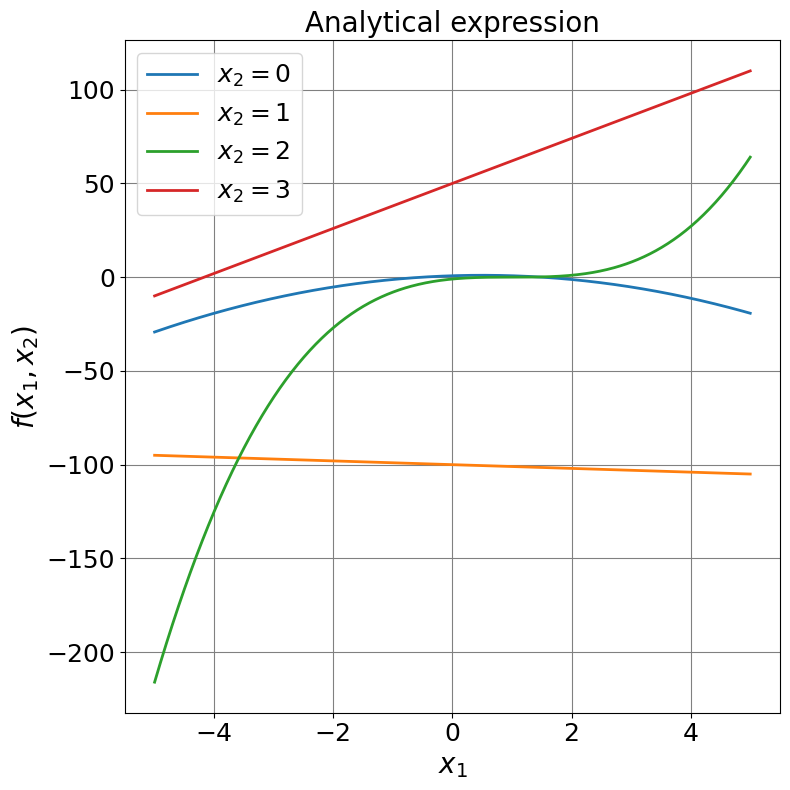

In [3]:
# Plot
plt.close('all')
fig = plt.figure(figsize=(8, 8))

# Plot for y = 0
plt.plot(x_values, Y[0], label=r'$x_2 = 0$', linewidth=2)

# Plot for y = 1
plt.plot(x_values, Y[1], label=r'$x_2 = 1$', linewidth=2)

# Plot for y = 2
plt.plot(x_values, Y[2], label=r'$x_2 = 2$', linewidth=2)

# Plot for y = 3
plt.plot(x_values, Y[3], label=r'$x_2 = 3$', linewidth=2)

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$f(x_1,x_2)$', fontsize=20)
plt.title('Analytical expression', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, color='gray')
plt.box(True)
plt.legend(fontsize=18)
plt.tight_layout()
fig.savefig("parc_analytical_fun.pdf")
fig.savefig("parc_analytical_fun.png")
plt.show()

### Fit with Piecewise affine surrogate
Reference file: <https://github.com/bemporad/PyPARC/blob/main/examples/parc_example_1.py>

In [4]:

from pyparc.parc import PARC
import math

np.random.seed(0)  # for reproducibility

K = 10
separation = 'Softmax'
# separation='Voronoi'
sigma = 1
alpha = 1.0e-4
beta = 1.0e-3
softmax_maxiter = 100000
maxiter = 15

xmin = -5
xmax = 5
ymin = 0
ymax = 3

cpu_time = {}

nyc = 1  # number of numeric outputs
categorical = False  # whether the output is categorical

# Get random split of training/test data
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=test_size)

tic = time.process_time()
predictor = PARC(K=K, alpha=alpha, sigma=sigma, separation=separation, maxiter=maxiter,
                 cost_tol=1e-4, min_number=10, fit_on_partition=True,
                 beta=beta, verbose=0)

# Y_hat, delta_hat = predictor.predict(X_test) # predict targets

predictor.fit(X_train, Y_train, categorical, weights=np.ones(1))
toc = time.process_time()
cpu_time["PWAS"] = toc - tic

print("Model fitting time required (%f)", (cpu_time["PWAS"]))

score_train = predictor.score(X_train, Y_train)  # compute R2 score on training data
score_test = predictor.score(X_test, Y_test)  # compute R2 score on test data


C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecat

Model fitting time required (%f) 1.71875


### print the score

In [5]:
print("\nResults:\n")
print("Training data: %6.2f %%" % (score_train[0] * 100))
print("Test data:     %6.2f %%" % (score_test[0] * 100))
print("--------------------\n")


Results:

Training data:  99.82 %
Test data:      99.82 %
--------------------


#### plot the results

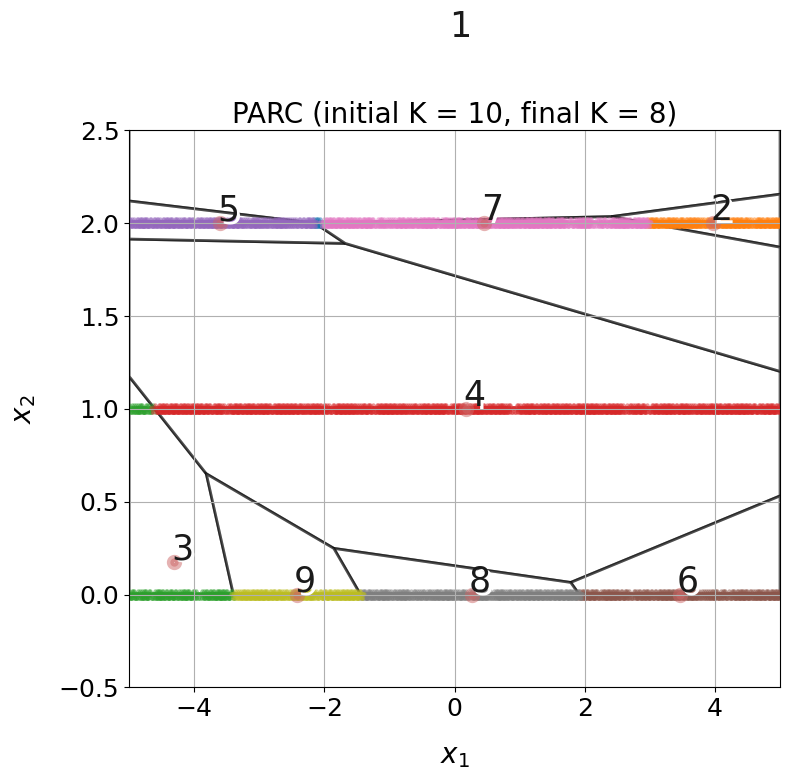

In [6]:
# Plot the partition

Kf = predictor.K  # final number of partitions
delta = predictor.delta  # final assignment of training points to clusters
xbar = predictor.xbar  # centroids of final clusters

Yhtrain, _ = predictor.predict(X_train)
Yhtest, delta_test = predictor.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(0, Kf):
    iD = (delta == i).ravel()
    plt.scatter(X_train[iD, 0], X_train[iD, 1], marker='*', linewidth=3,
                alpha=0.5, color=cm.tab10(i))
plt.grid()
plt.scatter(xbar[:, 0], xbar[:, 1], marker='o', linewidth=5, alpha=.5, color=(.8, .4, .4))


# Plot PWL partition
predictor.plot_partition([xmin, ymin], [xmax, ymax], fontsize=25,
                         ax=ax, alpha=.6, linestyle='-', linewidth=2.0, color=(1, 1, 1))
ax.set_xlim([xmin, xmax])
ax.set_ylim([-.5, 2.5])
ax.set_xlabel(r'$x_1$', labelpad=15, fontsize=20)
ax.set_ylabel(r'$x_2$', labelpad=15, fontsize=20)
for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(18)

plt.title('PARC (initial K = %d, final K = %d)' % (K, 8), fontsize=20)
plt.tight_layout()
fig.savefig("parc_partition.pdf")
fig.savefig("parc_partition.png")
plt.show()

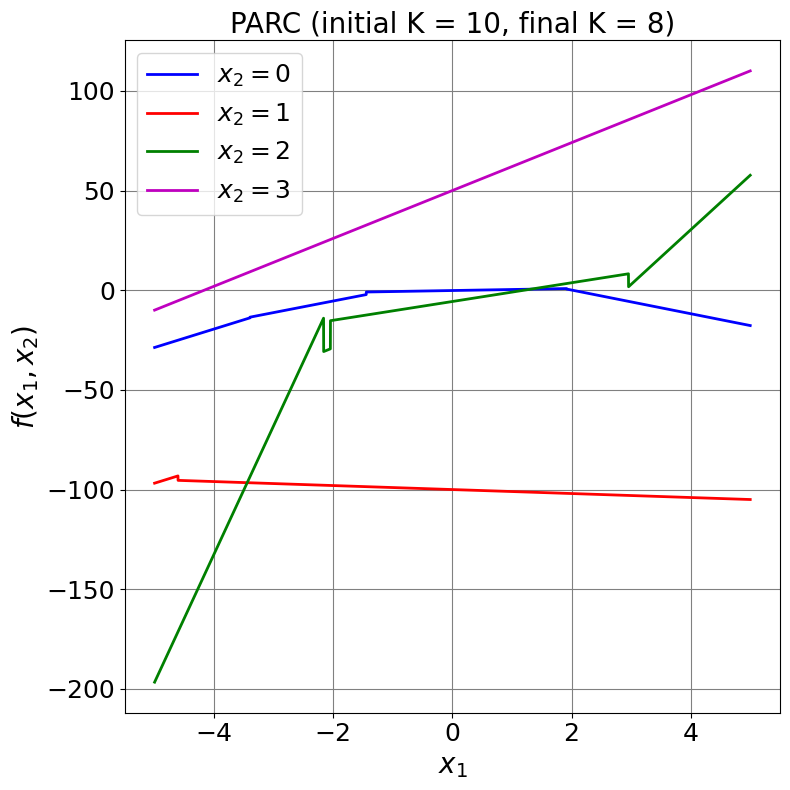

In [7]:
# Plot predictions

# Define x range
N_predict = N*10
x_topredict = np.linspace(-5, 5, N_predict)

# Define y categories
y_topredict  = [0, 1, 2, 3]

# Create a grid of x and y values
X1_topredict, X2_topredict= np.meshgrid(x_topredict, y_topredict)
X_topredict = np.transpose(np.array([X1_topredict.ravel(), X2_topredict.ravel()]))

zpwl, _ = predictor.predict(np.hstack((X_topredict[:,0].reshape(X_topredict[:,0].size, 1), X_topredict[:,1].reshape(X_topredict[:,1].size, 1))))
zpwl = zpwl.reshape(X_topredict[:,0].shape)


fig = plt.figure(figsize=(8, 8))

# Plot for y = 0
plt.plot(x_topredict, zpwl[:N_predict], 'b-', label=r'$x_2 = 0$', linewidth=2)

# Plot for y = 1
plt.plot(x_topredict, zpwl[N_predict:N_predict*2], 'r-', label=r'$x_2 = 1$', linewidth=2)

# Plot for y = 2
plt.plot(x_topredict, zpwl[N_predict*2:N_predict*3], 'g-', label=r'$x_2 = 2$', linewidth=2)

# Plot for y = 3
plt.plot(x_topredict, zpwl[N_predict*3:N_predict*4], 'm-', label=r'$x_2 = 3$', linewidth=2)

plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$f(x_1,x_2)$', fontsize=20)
plt.title('PARC (initial K = %d, final K = %d)' % (K, 8), fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, color='gray')
plt.box(True)
plt.legend(fontsize=18)
plt.tight_layout()
fig.savefig("parc_pwa.pdf")
fig.savefig("parc_pwa.png")
plt.show()


In [8]:
### Show the plots side by side
# from IPython.display import Image
# from IPython.display import display
# analytic_image = Image("parc_analytical_fun_example_2.png", width=10)
# pwas_image = Image("parc_pwa_surrogate_fun_example_2.png", width=10)
# 
# display(analytic_image, pwas_image)

### Fit with GP using different kernels

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [10]:
# Use the same training samples as for PWAS

X_continuous = X1.ravel()
tune_gp = True

# One-hot encode the categorical variable
encoder = OneHotEncoder(sparse_output=False, categories='auto')
X_categorical_encoded = encoder.fit_transform(X2.ravel().reshape(-1,1))
# Combine continuous and categorical variables into a single dataset
X_gp = np.hstack([X_continuous.reshape(-1,1), X_categorical_encoded])

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_gp, Y_, test_size=test_size)

if tune_gp:
    # Define kernels with tunable parameters
    kernels = [
        RBF(),  # Length scale will be tuned
        Matern(),  # Length scale and nu will be tuned
        DotProduct() + WhiteKernel()  # Noise level of WhiteKernel will be tuned
    ]

    # Define parameter grid for each kernel
    param_grid = [
        {'kernel': [RBF()], 'kernel__length_scale': [0.1, 1.0, 10.0]},
        {'kernel': [Matern()], 'kernel__length_scale': [0.1, 1.0, 10.0], 'kernel__nu': [0.5, 1.5, 2.5]},
        {'kernel': [DotProduct() + WhiteKernel()], 'kernel__k2__noise_level': [0.1, 1.0, 10.0]}
    ]
else:
    kernels = [
    RBF(length_scale=1.0),
    Matern(length_scale=1.0, nu=1.5),
    DotProduct() + WhiteKernel(noise_level=1)
    ]



In [11]:
# Train a Gaussian Process model with GridSearchCV for each kernel
results = {}
for i, kernel in enumerate(kernels):
    if tune_gp:
        tic = time.process_time()
        gp = GaussianProcessRegressor()
        grid_search = GridSearchCV(gp, param_grid[i], cv=3, n_jobs=-1, scoring='r2')
        grid_search.fit(X_train, y_train)
        toc = time.process_time()
        
        # Best model
        best_gp = grid_search.best_estimator_
        cpu_time[str(best_gp.kernel)] = toc - tic
        
         # Scoring
        train_score = best_gp.score(X_train, y_train)
        test_score = best_gp.score(X_test, y_test)
    else:
        tic = time.process_time()
        kernel_name = str(kernel)  # Convert the kernel object to a string
        gp = GaussianProcessRegressor(kernel=kernel)
        gp.fit(X_train, y_train)
        toc = time.process_time()
        cpu_time[str(kernel)] = toc - tic
    
        #Scoring
        train_score = gp.score(X_train, y_train)
        test_score = gp.score(X_test, y_test)

    
    if tune_gp:
        # Store results
        results[str(best_gp.kernel)] = {
            "train_score": train_score,
            "test_score": test_score,
            "best_params": grid_search.best_params_,
            "best_gp": best_gp
        }
    else:
        results[str(kernel)] = {
            "train_score": train_score,
            "test_score": test_score,
            "best_gp": gp
        }


C:\Anaconda3\envs\ExpDesign\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [12]:
cpu_time

{'PWAS': 1.71875,
 'RBF(length_scale=0.1)': 57.9375,
 'Matern(length_scale=0.1, nu=2.5)': 10.53125,
 'DotProduct(sigma_0=1) + WhiteKernel(noise_level=10)': 25.59375}

In [13]:
print("\nResults:\n")
for i, (kernel_name, res) in enumerate(results.items()):
    print(f"Training data {kernel_name}: %6.2f %%" % (res['train_score'] * 100))
    print(f"Test data {kernel_name}:     %6.2f %%" % (res['test_score'] * 100))
    print("--------------------\n")


Results:

Training data RBF(length_scale=0.1): 100.00 %
Test data RBF(length_scale=0.1):     100.00 %
--------------------

Training data Matern(length_scale=0.1, nu=2.5): 100.00 %
Test data Matern(length_scale=0.1, nu=2.5):     100.00 %
--------------------

Training data DotProduct(sigma_0=1) + WhiteKernel(noise_level=10):  25.71 %
Test data DotProduct(sigma_0=1) + WhiteKernel(noise_level=10):      29.57 %
--------------------


In [14]:
# One-hot encode the categorical variable
encoder = OneHotEncoder(sparse_output=False, categories='auto')
X_categorical_encoded_toPred = encoder.fit_transform(X2_topredict.ravel().reshape(-1,1))
# Combine continuous and categorical variables into a single dataset
X_topredict_gp = np.hstack([X1_topredict.reshape(-1,1), X_categorical_encoded_toPred])

results_plot = {}
for i, (kernel_name, res) in enumerate(results.items()):
    best_gp = res["best_gp"]
    y_pred, y_std = best_gp.predict(X_topredict_gp, return_std=True)
    
    results_plot[str(best_gp.kernel)] = {
        "y_pred": y_pred,
        "y_std": y_std,
    }
    

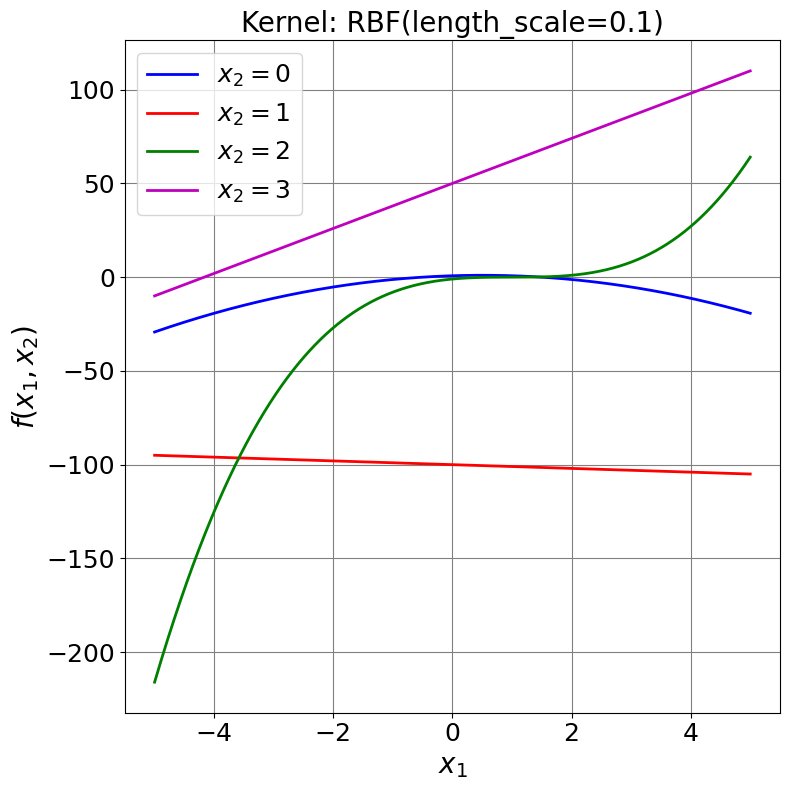

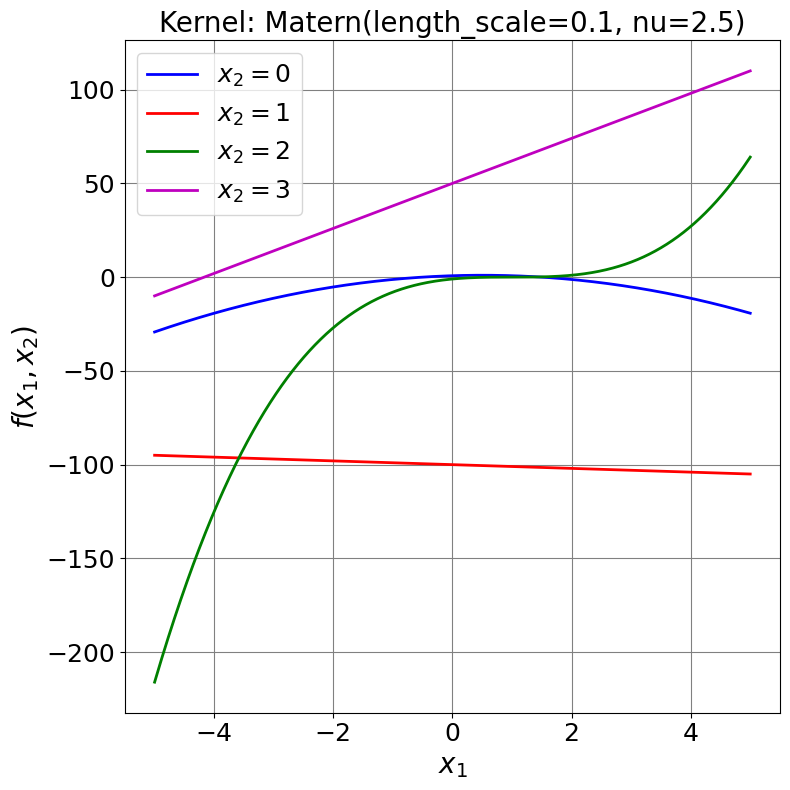

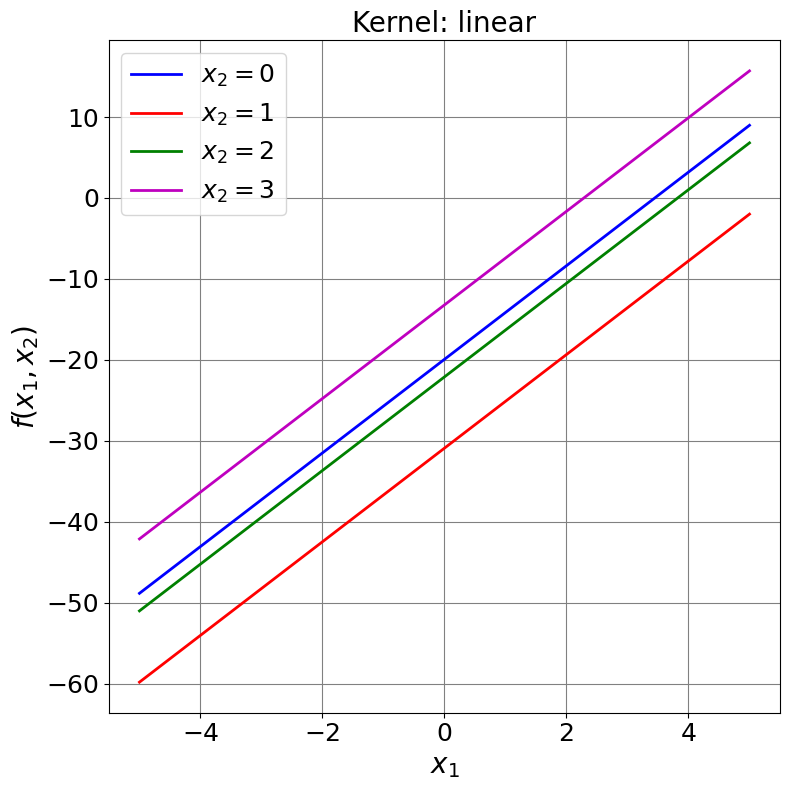

In [15]:
# Plotting the results
# fig = plt.figure(figsize=(10, 15))
for i, (kernel_name, res) in enumerate(results_plot.items()):
    # plt.subplot(3, 2, i + 1)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(x_topredict, res["y_pred"][:N_predict], 'b-', label=r'$x_2 = 0$', linewidth=2)
    plt.plot(x_topredict, res["y_pred"][N_predict:N_predict*2], 'r-', label=r'$x_2 = 1$', linewidth=2)
    plt.plot(x_topredict, res["y_pred"][N_predict*2:N_predict*3], 'g-', label=r'$x_2 = 2$', linewidth=2)
    plt.plot(x_topredict, res["y_pred"][N_predict*3:N_predict*4], 'm-', label=r'$x_2 = 3$', linewidth=2)
    # plt.fill_between(x_topredict.ravel(), 
    #                  res["y_pred"][:N_predict] - 1.96 * res["y_std"][:N_predict], 
    #                  res["y_pred"][:N_predict] + 1.96 * res["y_std"][:N_predict], 
    #                  alpha=0.2, color='blue', label="95% Confidence Interval")
    # plt.fill_between(x_topredict.ravel(), 
    #              res["y_pred"][N_predict:N_predict*2] - 1.96 * res["y_std"][N_predict:N_predict*2], 
    #              res["y_pred"][N_predict:N_predict*2] + 1.96 * res["y_std"][N_predict:N_predict*2], 
    #              alpha=0.2, color='blue', label="95% Confidence Interval")
    if i == 2:
        kernel_name = 'linear'
        
    plt.title(f"Kernel: {kernel_name}", fontsize=20)
    plt.xlabel(r'$x_1$', fontsize=20)
    plt.ylabel(r'$f(x_1,x_2)$', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(True, color='gray')
    plt.box(True)
    plt.legend(fontsize=18)
    
    plt.tight_layout()
    fig.savefig(f"parc_gp_{kernel_name}.pdf")
    fig.savefig(f"parc_gp_{kernel_name}.png")
    plt.show()

# plt.tight_layout()
# fig.savefig("parc_gp_surrogate_fun_example_2.pdf")
# fig.savefig("parc_gp_surrogate_fun_example_2.png")
# plt.show()